<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting" data-toc-modified-id="Setting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting</a></span><ul class="toc-item"><li><span><a href="#Path" data-toc-modified-id="Path-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Path</a></span></li></ul></li><li><span><a href="#時系列データ作成" data-toc-modified-id="時系列データ作成-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>時系列データ作成</a></span></li><li><span><a href="#入力データ作成" data-toc-modified-id="入力データ作成-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>入力データ作成</a></span></li><li><span><a href="#Load-Model" data-toc-modified-id="Load-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Model</a></span></li><li><span><a href="#Visualize-conv1d_1-Outputs" data-toc-modified-id="Visualize-conv1d_1-Outputs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize conv1d_1 Outputs</a></span><ul class="toc-item"><li><span><a href="#Ch00-[0-59]" data-toc-modified-id="Ch00-[0-59]-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Ch00 [0-59]</a></span><ul class="toc-item"><li><span><a href="#plot" data-toc-modified-id="plot-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>plot</a></span></li><li><span><a href="#Convolve-Output" data-toc-modified-id="Convolve-Output-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Convolve Output</a></span></li></ul></li></ul></li><li><span><a href="#End" data-toc-modified-id="End-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>End</a></span></li></ul></div>

# 一次元データ_Conv1d_重み可視化__sinFunc.ipynb

0. データ作成
  - 単なるsin関数を含んだ式
  - ノイズを加える
  - 異常波形作成
0. CNN時系列予測
  - [時系列予測を一次元畳み込みを使って解く with Keras - Qiita
      ](https://qiita.com/niisan-tokyo/items/a94dbd3134219f19cab1)
  - その背景を $windowsize$ 5-60程度で予測するConv1d層の作成
0. LSTMによる異常検出？
  - Conv1dで畳み込んだあとでLSTM層にぶち込めばよい？
  - LSTM層では異常かそうでないかの判別
    - 簡単にするために $\textbf{正常}:\textbf{異常}=1:1$ とするのが良さそう

In [1]:
ipynb_title = "visualize_Conv1d_model__SinCosFunc"

In [2]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path

import keras
print("Keras version : ", keras.__version__)

Using TensorFlow backend.


Keras version :  2.1.6


## Setting

### Path

In [3]:
HOME = Path(os.getcwd()).parent
print(HOME)

/home/pollen/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku


In [4]:
path_list = []
keras_model_h5_Path = HOME / "keras_model_h5_Path"
path_list.append(keras_model_h5_Path)
data_Path = HOME / "data"
path_list.append(data_Path)
plot_image_Path = data_Path / "plot_images"
path_list.append(plot_image_Path)

for _Path in path_list:
    _path = str(_Path)
    if not os.path.exists(_path):
        os.makedirs(name=_path)
        print("make a directory: \n\t", _path)
    else:
        print(os.path.exists(_path), ": ", _path)

True :  /home/pollen/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5_Path
True :  /home/pollen/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/data
True :  /home/pollen/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/data/plot_images


## 時系列データ作成

$$
\textbf{toy_func(t)} = 
  20 \cdot \left( 
    \sin\left( \frac{2\pi}{T} t \right)
    + \cos\left( 2 \cdot \frac{2\pi}{T} t \right)
    + \sin\left( 3 \cdot \frac{2\pi}{T} t \right)
    + \cos\left( 4 \cdot \frac{2\pi}{T} t \right)
  \right)
  + \frac{1}{5} t
  + \varepsilon
$$

In [5]:
def mySin(t, period=100):
    """
    時刻t, 周期period
    """
    return np.sin(2.0 * np.pi * t/period)

def myCos(t, period=100):
    """
    時刻t, 周期period
    """
    return np.cos(2.0 * np.pi * t/period)

In [6]:
# Add Noise
def toy_func(tStart=0, tStop=100, tStep=1, triAmpl=20, tAmpl=0.5, noiseAmpl=0.05):
    """
    T : 
      sin波の周期
    ampl : 
      ノイズ振幅調整
      """
    t = np.arange(start=tStart, stop=tStop, step=tStep)
    noise = noiseAmpl * np.random.randn(t.shape[0])  # mean=0, standard_deviation=1
    return (t,
            triAmpl * ( mySin(t, period=100)
                        + mySin(t=3*t, period=100)
                        + myCos(t=2*t, period=100)
                        + myCos(t=4*t, period=100) )
            #+ tAmpl * t
            + noise )

## 入力データ作成

In [7]:
windowsize = 60
predictsize = 1

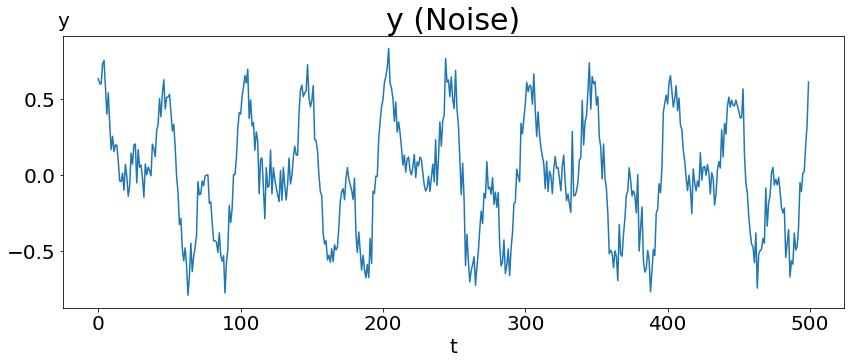

In [29]:
wave_size = 500
t, y = toy_func(tStop=wave_size, triAmpl=1./4, tAmpl=0.0, noiseAmpl=0.1)

fig = plt.figure(figsize=(14,5))  # (width, height)
ax = fig.add_subplot(1,1,1)
ax.plot(t, y)

title = "y (Noise)"
ax.set_title(label=title, fontsize=30)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="y", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=0.0, y=1.02)
ax.tick_params(labelsize=20)

plt.show()

In [9]:
input_arr = np.empty(shape=(0, windowsize))
print(input_arr.shape)
for i in range( y.shape[0] - (windowsize + predictsize) + 1 ):
    input_arr = np.append(arr=input_arr,
                           values=y[i:(i+windowsize)].reshape(1, -1),
                           axis=0)
print("input_arr.shape  : ", input_arr.shape)
input_arr = input_arr.reshape((-1, windowsize, 1))
print("input_arr.shape  : ", input_arr.shape)

(0, 60)
input_arr.shape  :  (440, 60)
input_arr.shape  :  (440, 60, 1)


## Load Model

In [10]:
from keras.models import load_model

In [11]:
modelpath = str(keras_model_h5_Path / "model__create_Conv1d_model__SinCosFunc.h5")
model = load_model(filepath=modelpath)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 60, 60)            660       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 60)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 60)            36060     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6, 60)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 30)             18030     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 30)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 15)             4515      
__________

## Visualize conv1d_1 Outputs

In [13]:
from keras.models import Model
output_layer_name = 'conv1d_1'
hidden_layer_model = Model(inputs=model.input,
                           outputs=model.get_layer(output_layer_name).output)

In [14]:
hidden_layer_output = hidden_layer_model.predict(x=input_arr)
print(hidden_layer_output.shape)

(440, 60, 60)


### Ch00 [0-59]

#### plot

In [16]:
ch = 0
#--------------------------------------------------------------------------------
# Setting Parameter
#--------------------------------------------------------------------------------
title = ipynb_title + "__" + "channel00_allWindow"
filename = title + ".png"

In [17]:
#--------------------
# Resize
#--------------------
weights = hidden_layer_output[:, :, ch].squeeze()
print(weights.shape)
weights = weights.T
print(weights.shape)

(440, 60)
(60, 440)


In [18]:
#--------------------
# get max value for plot ylim
#--------------------
print("max : ", np.max(weights))
print("min : ", np.min(weights))
max_abs = np.maximum(np.max(weights),
                     abs(np.min(weights))
                    )
print("max abs : ", max_abs)

max :  0.4833307
min :  0.0
max abs :  0.4833307


(-0.5, 439.5)
(59.5, -0.5)
1.222222222222222


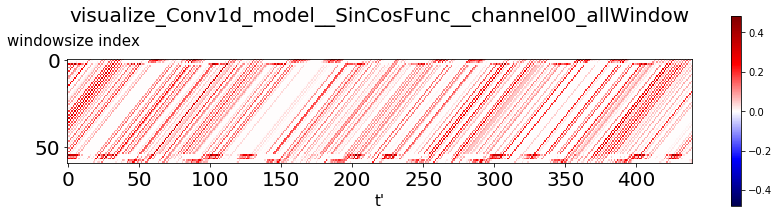

In [19]:
#--------------------------------------------------------------------------------
# Plot
#--------------------------------------------------------------------------------
figsize=(14, 7)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
mappable = ax.imshow(weights,
                     cmap='seismic',  # <-- (min,max)=(blue, red)
                     vmin=-max_abs,
                     vmax=max_abs,
                     )
fig.colorbar(mappable,
             ax=ax,
             #orientation='horizontal',
             orientation='vertical',
             shrink=0.5,
             )

#----------------------------------------
# change x,y axis ratio
#----------------------------------------
# height is aspect_num times the width
print(ax.get_xlim())
print(ax.get_ylim())
xratio = 6
aspect = (1/xratio) * (ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[0] - ax.get_ylim()[1])
print(aspect)
ax.set_aspect(aspect=aspect,)

#----------------------------------------
# plot config
#----------------------------------------
ax.set_title(label=title, fontsize=20, y=1.3)
ax.set_xlabel(xlabel="t'", fontsize=15)
ax.set_ylabel(ylabel="windowsize index", fontsize=15, rotation=0)
ax.yaxis.set_label_coords(x=0.01, y=1.1)  # ylabel position
ax.tick_params(labelsize=20)  # tick fontsize

fig.savefig(fname=str(plot_image_Path / filename))
plt.show()

#### Convolve Output

<img src="./images/fig01.png">

In [20]:
figsize = (25, 10)
cmap = "seismic"

In [58]:
#--------------------------------------------------------------------------------
# Setting Parameter
#--------------------------------------------------------------------------------
ch = 0
title = ipynb_title + "__channel00__convolveWindows"
filename = title + ".png"

In [59]:
#----------------------------------------
# Convolved window size
#----------------------------------------
weights_tmp = hidden_layer_output[:, :, ch].squeeze()
weights_tmp = weights_tmp.T

# Prepare for convolved
weights = np.empty(shape=(0, wave_size-1))
for window_idx in range(windowsize):
    _shape = weights_tmp.shape[1]
    # append last
    if window_idx < windowsize-1:
        _val = weights_tmp[-1, -windowsize+window_idx+1:]
        insert_arr = np.append(arr=weights_tmp[window_idx],
                               values=_val,
                               axis=None)
    else:
        insert_arr = weights_tmp[window_idx]

    # insert first
    _val = weights_tmp[0, :window_idx]
    insert_arr = np.insert(arr=insert_arr,
                           obj   =[0 for i in range(window_idx)],
                           values=_val,
                           ).reshape(1, -1)
    # append to the array
    #print(insert_arr.shape)
    weights = np.append(
        arr=weights,
        values=insert_arr,
        axis=0,
    )
print("weights.shape : ", weights.shape)

weights.shape :  (60, 499)


In [60]:
# Convolved
weights_convolve_windows = weights.sum(axis=0).reshape(1, -1)
print("weights_convolve_windows.shape : ", weights_convolve_windows.shape)

weights_convolve_windows.shape :  (1, 499)


In [61]:
#--------------------
# get max value for plot ylim
#--------------------
print("max : ", np.max(weights_convolve_windows))
print("min : ", np.min(weights_convolve_windows))
max_abs = np.maximum(np.max(weights_convolve_windows),
                     abs(np.min(weights_convolve_windows))
                    )
print("max abs : ", max_abs)

max :  16.873507775366306
min :  0.0
max abs :  16.873507775366306


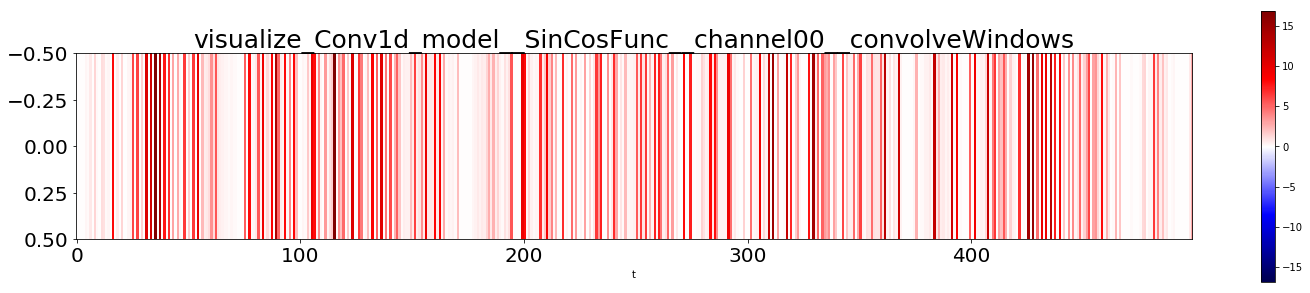

In [63]:
#--------------------------------------------------------------------------------
# Plot
#--------------------------------------------------------------------------------
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
mappable = ax.imshow(weights_convolve_windows,
                     cmap='seismic',  # <-- (min,max)=(blue, red)
                     vmin=-max_abs,
                     vmax=max_abs,
                     )
fig.colorbar(mappable,
             ax=ax,
             orientation='vertical',
             shrink=0.5,
             )

#----------------------------------------
# change x,y axis ratio
#----------------------------------------
# height is aspect_num times the width
xratio = 6
aspect = (1/xratio) * (ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[0] - ax.get_ylim()[1])
ax.set_aspect(aspect=aspect,)

#----------------------------------------
# plot config
#----------------------------------------
ax.set_title(label=title, fontsize=25)
ax.set_xlabel(xlabel="t")
ax.set_ylabel(ylabel="")
ax.tick_params(labelsize=20)

fig.savefig(fname=filename)
plt.show()

## End